# Neural Networks - MNIST

Previously, I have worked on classifying the MNIST(Handwritten digits) data using Linear Regression, KNN, Naive Bayes, Logistic Regression, SVM, and Neural Networks. But for the neural networks, I have used scikit-learn library. Even though I understand the internal woeking of a stotastic gradient decent, I haven't had the chance to implement it the last time. So now, I'm going to implement a Neural Network from the scratch.

In [1]:
# Importing statements

# For extracting and loading the data
import pickle, gzip
# For math computations
import numpy as np
# To randomly initialize bias and weights for the first initialization
import random
# To clock the time taken
import time
# To plot the accuracy and classification results
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# To save and load the neural network into a file
import json
import sys

In [2]:
# Extracting the .pkl file and loading it as training, validation, and test data sets.
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as file :
        u = pickle._Unpickler(file)
        # There is some weird encoding problem when switching from py2 - py3, so have to use this encoding.
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    return (train_set, valid_set, test_set)


def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    testing_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, testing_data)


# Generic functions used throughout the program

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [3]:
training_data, validation_data, testing_data = load_data_wrapper()

In [14]:
class Network(object):

    def __init__(self, hidden_layers_sizes):
        # The initialization parameter takes in the array containing 
        # number of hidden layers. As this problem's input is a 28*28
        # pixel data, the first(input) layer is 784 and the output layer 
        # is 10 as we need classification of digits from 0-9.
        hidden_layers_sizes.insert(0, 784)
        hidden_layers_sizes.insert(len(hidden_layers_sizes), 10)
        self.num_layers = len(hidden_layers_sizes)
        self.hidden_layers_sizes = hidden_layers_sizes
        
        
        # The biases and weights for the network are initialized 
        # randomly, using a Gaussian distribution with mean 0, 
        # and variance 1.  Note that the first layer is assumed 
        # to be an input layer, and by convention we won't set 
        # any biases for those neurons, since biases are only
        # ever used in computing the outputs from later layers.
        self.biases = [np.random.randn(y, 1) for y in hidden_layers_sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(hidden_layers_sizes[:-1], hidden_layers_sizes[1:])]

    def classify(self, x):
        # Simply compute W*x+B
        for b, w in zip(self.biases, self.weights):
            x = sigmoid(np.dot(w, x)+b)
        return x

    def SGD(self, training_data, epochs, mini_batch_size, learning_rate,
            testing_data=None):
        self.accuracy = np.zeros(epochs)
        self.correct_classification_count = np.zeros(epochs)
        # Here we train the neural network using stochastic
        # gradient descent in batches. 
        # We randomly shuffle the data and pick a certain sized
        # batch to perform the model training and weight updations
        if testing_data: n_testing_data = len(testing_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            # Self explanatory - Evaluate the model by classifying
            # on every iteration if there is test data available.
            if testing_data:
                self.correct_classification_count[j] = self.evaluate(testing_data)
                self.accuracy[j] = (self.correct_classification_count[j]/n_testing_data)*100
        fig = plt.figure(figsize=(20,10))
        fig.suptitle("Accuracy VS Epoch Graph")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(self.accuracy)
        print("Maximum Accuracy = ",max(self.accuracy),"%")        

    def update_mini_batch(self, mini_batch, learning_rate):
        # What we are doing is taking a mini-batch and performing
        # stocastic gradient decent using backpropagation on that
        # and modifying the weights and re-iterating the procedure
        # again for the given number of epochs.
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # Nabla here stands for gradient
        for x, y in mini_batch:
            # Here we fetch the difference we need to make to the
            # weights and bias in order to reduce the cost function.
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # As we are doing batch based weight updation, we should tone
        # it down to ensure we don't go overboard in finding the minima.
        self.weights = [w-(learning_rate/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(learning_rate/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # Returns a tuple representing the gradient for the cost 
        # function. nabla_b and nabla_w are layer-by-layer lists
        # of numpy arrays, similar to self.biases and self.weights
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activation = x
        # List to store all the activations, layer by layer
        activations = [x] 
        # List to store all the z (Wx+B) vectors, layer by layer
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # Backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Here, -1 means the last layer of neurons, -2 is the
        # second-last layer, and so on.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, testing_data):
        # Returns the number of test inputs for which the neural
        # network outputs the correct result. Note that the neural
        # network's output is assumed to be the index of whichever
        # neuron in the final layer has the highest activation.        
        test_results = [(np.argmax(net.classify(x)), y) 
                        for (x, y) in testing_data]
        return sum(int(x==y) for (x, y) in test_results)
    
    def check_wrong_evaluations(self, testing_data):
        # Returns the number of test inputs for which the neural
        # network outputs the correct result. Note that the neural
        # network's output is assumed to be the index of whichever
        # neuron in the final layer has the highest activation.        
        self.wrong_classifications = []
        test_results = [(np.argmax(net.classify(x)), y) 
                        for (x, y) in testing_data]
        count = 0
        for index,(x, y) in enumerate(test_results):
            if(int(x != y)):
                self.wrong_classifications.append(index)
            else:
                count+=1
        return count;

    # As the cost fucntion is ((y-sigmoid(y_pred))^2)/2
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

The Layers in the NN are:  [784, 50, 30, 10]
Maximum Accuracy =  94.96 %
Time taken =  149.89649510383606 s


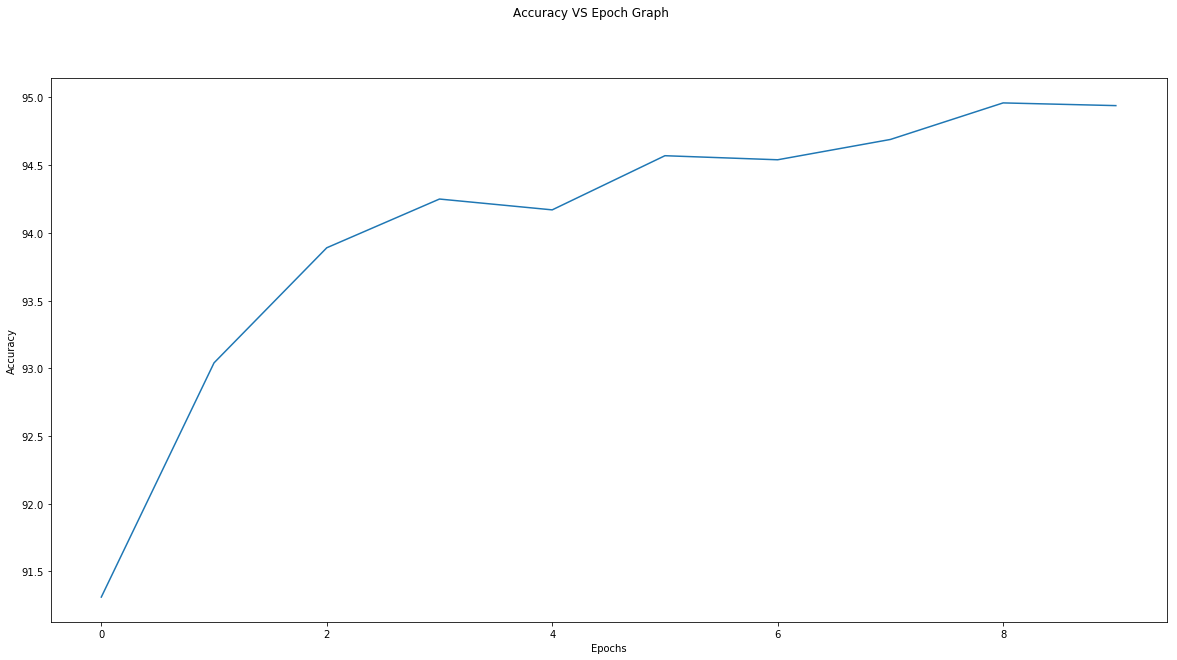

In [15]:
net = Network([50,30])
print("The Layers in the NN are: ",net.hidden_layers_sizes)
start = time.time()
net.SGD(training_data, 10, 5, 3, testing_data=testing_data)
print ("Time taken = ", time.time()-start,"s")

In [6]:
def plot_mnist_digit(x):
    # This function plots the digit given a 28*28 matrix.
    fig = plt.figure(figsize=(15, 15))
    size = len(x)
    i = size/4
    j = 1
    for k in x:
        image = np.reshape(testing_data[net.wrong_classifications[k]][0],(28,28))
        ax = fig.add_subplot(i, 4, j)
        ax.matshow(image, cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        j+=1
        #print("Actual Value: ",testing_data[net.wrong_classifications[k]][1])
        #print("Predicted Value: ",np.argmax(net.classify(testing_data[net.wrong_classifications[k]][0])))
    plt.show()

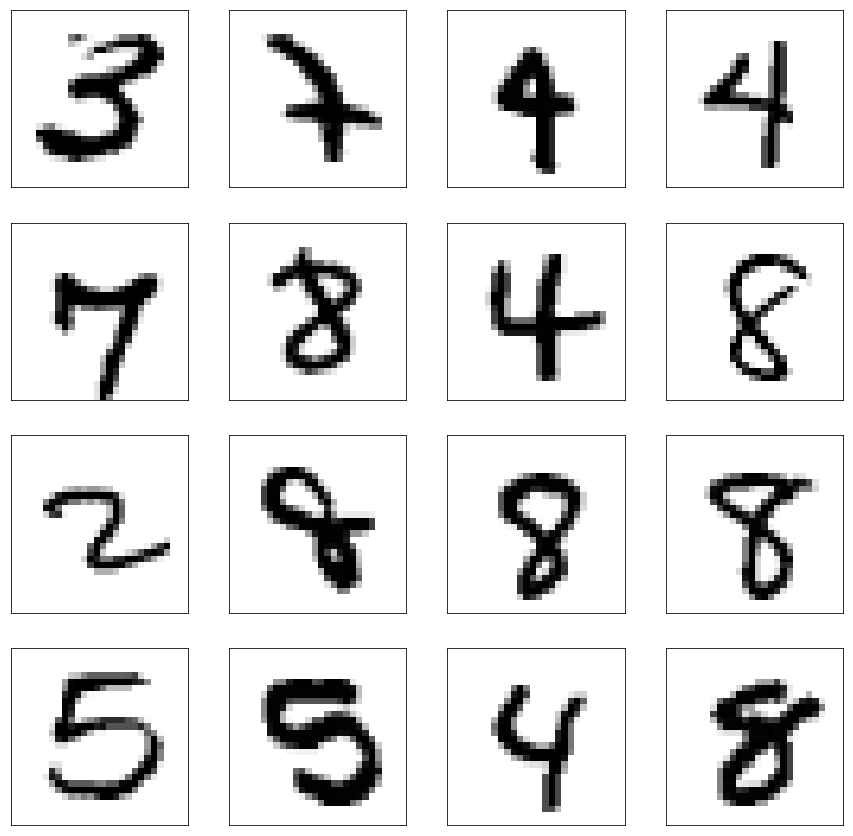

In [7]:
# Let us plot some digits with their correct classification 
# This enables us to visualize how they are structured.
net.check_wrong_evaluations(testing_data)
x = [random.randint(0,len(net.wrong_classifications)-1) for i in range(1,17)]
plot_mnist_digit(x)

In [8]:
def plot_really_bad_images():
    """This takes a list of the worst images from plot_bad_images and
    turns them into a figure."""
    really_bad_image_indices = [
        324, 582, 659, 726, 846, 956, 1124, 1393,
        1773, 1868, 2018, 2109, 2654, 4199, 4201, 4620, 5457, 5642]
    n = len(really_bad_image_indices)
    really_bad_images = [np.reshape(testing_data[j][0],(28,28)) for j in really_bad_image_indices]
    fig = plt.figure(figsize=(15, 10))
    for j in range(1, n+1):
        ax = fig.add_subplot(3, 6, j)
        ax.matshow(really_bad_images[j-1], cmap = matplotlib.cm.binary)
        #ax.set_title(str(really_bad_image_indices[j-1]))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

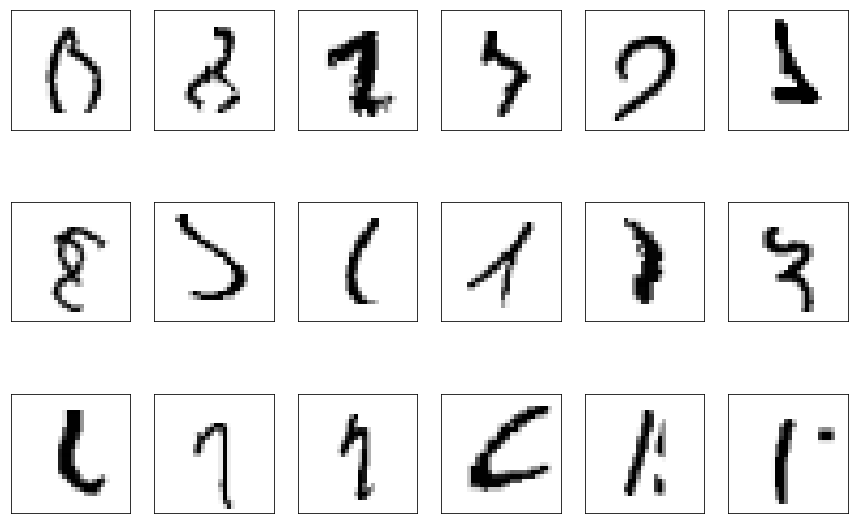

In [9]:
plot_really_bad_images()

As we can see that, we acheived a decent accuracy with not much tweaking. Down the line, we would implement techniques to increase the accuracy of the classifier. 


This project is a part of machine learning tasks I would want to learn and explore. They are listed below:
- MNIST dataset classification with optimizations
- Imagenet using Tensor Flow
- Video object recognition

In this section we would improve the learning rate of the neural network. 


As we could observe, the primary limitation in terms of slowing down the learning rate is the partial derivative of the cost function. The existing one resists faster learning. So unless we modify the cost function, we would not be able to achieve a better result. 


Improvements in the below section include the addition of the cross-entropy cost function, regularization, and better initialization of network weights.  

In [19]:
# We modify the cost from a linear to a quadratic cost.
class QuadraticCost(object):

    @staticmethod
    def cost_function(y_pred, y):
        return 0.5*np.linalg.norm(y_pred-y)**2

    @staticmethod
    def delta(z, y_pred, y):
        # Returns the error delta from the output layer.
        return (y_pred-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def cost_function(y_pred, y):
        # Note that np.nan_to_num is used to ensure numerical
        # stability.  In particular, if both a and y have a 1.0
        # in the same slot, then the expression (1-y)*np.log(1-a)
        # returns nan.  The np.nan_to_num ensures that that is converted
        # to the correct value (0.0).

        return np.sum(np.nan_to_num(-y*np.log(y_pred)-(1-y)*np.log(1-y_pred)))

    @staticmethod
    def delta(z, y_pred, y):
        # Returns the error delta from the output layer.  Note that the
        # parameter z is not used by the method.  It is included in
        # the method's parameters in order to make the interface
        # consistent with the delta method for other cost classes.
        
        return (y_pred-y)

    
class Network2(object):

    def __init__(self, hidden_layers_sizes, cost):
        # The initialization parameter takes in the array containing 
        # number of hidden layers. As this problem's input is a 28*28
        # pixel data, the first(input) layer is 784 and the output layer 
        # is 10 as we need classification of digits from 0-9.
        hidden_layers_sizes.insert(0, 784)
        hidden_layers_sizes.insert(len(hidden_layers_sizes), 10)
        self.num_layers = len(hidden_layers_sizes)
        self.sizes = hidden_layers_sizes
        self.large_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        # Initialize each weight using a Gaussian distribution with mean 0
        # and standard deviation 1 over the square root of the number of
        # weights connecting to the same neuron.  Initialize the biases
        # using a Gaussian distribution with mean 0 and standard
        # deviation 1.

        # Note that the first layer is assumed to be an input layer, and
        # by convention we won't set any biases for those neurons, since
        # biases are only ever used in computing the outputs from later
        # layers.
        
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[:])]

    def large_weight_initializer(self):
        # Refer above for details
        
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def classify(self, a):
        # Here a is the X values, and a that we are returning is the y_pred
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a


    def SGD(self, training_data, epochs, mini_batch_size, learning_rate,
            lmbda = 0.0, evaluation_data=None, monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False, monitor_training_cost=False,
            monitor_training_accuracy=False):
        
        # Here lambda is the regularization parameter
        if evaluation_data: n_evaluation_data = len(evaluation_data)
        n_training_data = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n_training_data, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, learning_rate, lmbda, n_training_data)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append((accuracy/n_evaluation_data)*100)
        fig = plt.figure(figsize=(20,10))
        fig.suptitle("Accuracy VS Epoch Graph")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(evaluation_accuracy)
        self.max_evaluation_accuracy = max(evaluation_accuracy)
        print("Maximum Accuracy = ",max(evaluation_accuracy),"%")
        net_test = load("best_NN.json")
        if(max(evaluation_accuracy) > net_test.max_evaluation_accuracy):
            self.save("best_NN.json")
        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy


    def update_mini_batch(self, mini_batch, learning_rate, lmbda, n):
        # This is the same as the Network1 class's function with an 
        # additional regularization parameter lmbda
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-learning_rate*(lmbda/n))*w-(learning_rate/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(learning_rate/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # This is also exactly the same as in Network1 class
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        # List to store all the activations, layer by layer
        activations = [x] 
        # List to store all the z vectors, layer by layer
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # Backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        # The flag convert should be set to False if the data set is
        # validation or test data (the usual case), and to True if the
        # data set is the training data. The need for this flag arises
        # due to differences in the way the results y are represented
        # in the different data sets.  In particular, it flags whether
        # we need to convert between the different representations. It
        # may seem strange to use different representations for the
        # different data sets. Why not use the same representation for
        # all three data sets?  It's done for efficiency reasons.
        # The program usually evaluates the cost on the training data
        # and the accuracy on other data sets. 
        
        if convert:
            results = [(np.argmax(self.classify(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.classify(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        # Returns the total cost for the data set. The flag convert 
        # should be set to False if the data set is the training data 
        # (the usual case), and to True if the data set is the 
        # validation or test data.  
        
        cost = 0.0
        for x, y in data:
            a = self.classify(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.cost_function(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost

    def save(self, filename):
        # Saves the neural network to the file
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__),
                "max_evaluation_accuracy": self.max_evaluation_accuracy}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()


def load(filename):
    # Loads the neural network from the file and returns
    # an instance of Network with weights and bias initialized
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network2(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    net.max_evaluation_accuracy = data["max_evaluation_accuracy"]
    return net

The Layers in the NN are:  [784, 30, 10]
Maximum Accuracy =  96.19 %
Time taken =  210.01492404937744 s


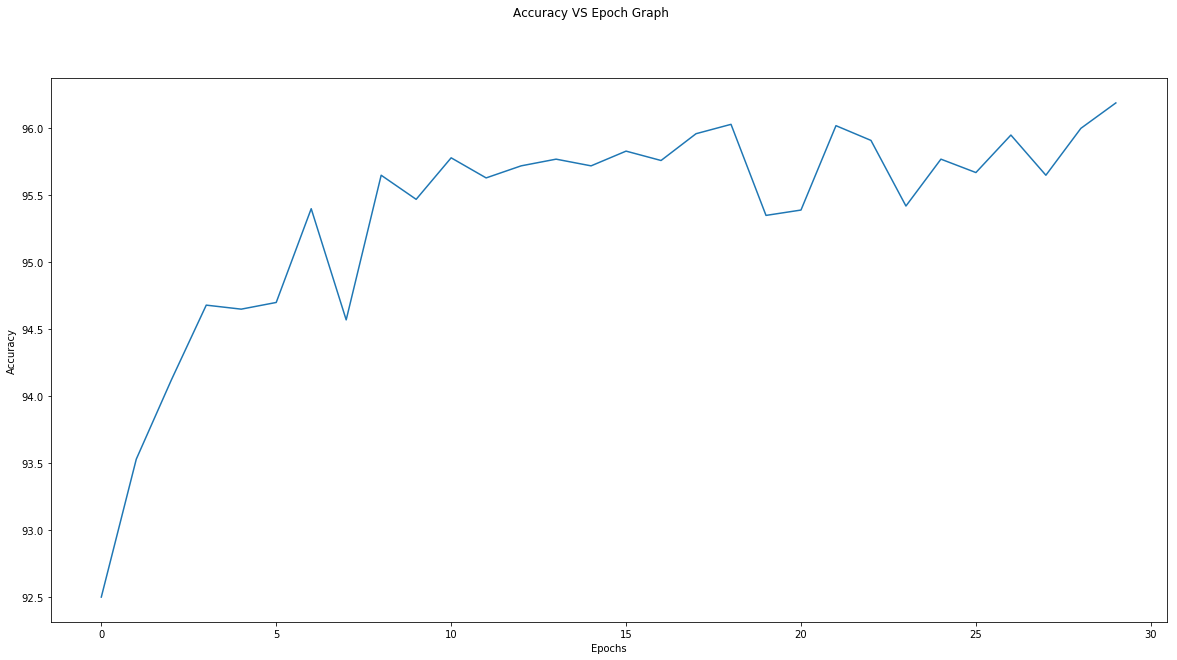

In [26]:
net2 = Network2([30], cost=CrossEntropyCost)
print("The Layers in the NN are: ",net2.sizes)
start = time.time()
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net2.SGD(
    training_data, 30, 10, 0.5, lmbda = 5.0, 
    evaluation_data=validation_data, 
    monitor_evaluation_accuracy=True)
print ("Time taken = ", time.time()-start,"s")

The final result is a classification accuracy of 97.94 percent on the validation data. 

That's a big jump from the previous scenarios where we might have been trapped into local minima which is now sorted(thanks to regularization).

And another advantage of using regularization is that we can easily replicate the results.

In [27]:
net_test = load("best_NN.json")
net_test.max_evaluation_accuracy

96.19